## Import & Normalize MNIST

In [80]:

import torch
print(torch.__version__)

from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

2.5.1+cpu


In [81]:
to_tensor = transforms.ToTensor()

normalize_transform = transforms.Compose([
    to_tensor,                    
    transforms.Normalize((0.1307,), (0.3081,))      
])

In [82]:
mnist_trainset = datasets.MNIST(root='/data', train= True, download=True, transform=normalize_transform)

In [83]:
train_size = int(0.8 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
mnist_trainset, mnist_valset = random_split(mnist_trainset, [train_size, val_size])

In [84]:
mnist_testset = datasets.MNIST(root='/data', train=False, download=True, transform=normalize_transform)

In [85]:
def visualize_mnist(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:
            break
        image, label = dataset[i]
        ax.imshow(image.squeeze().numpy(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

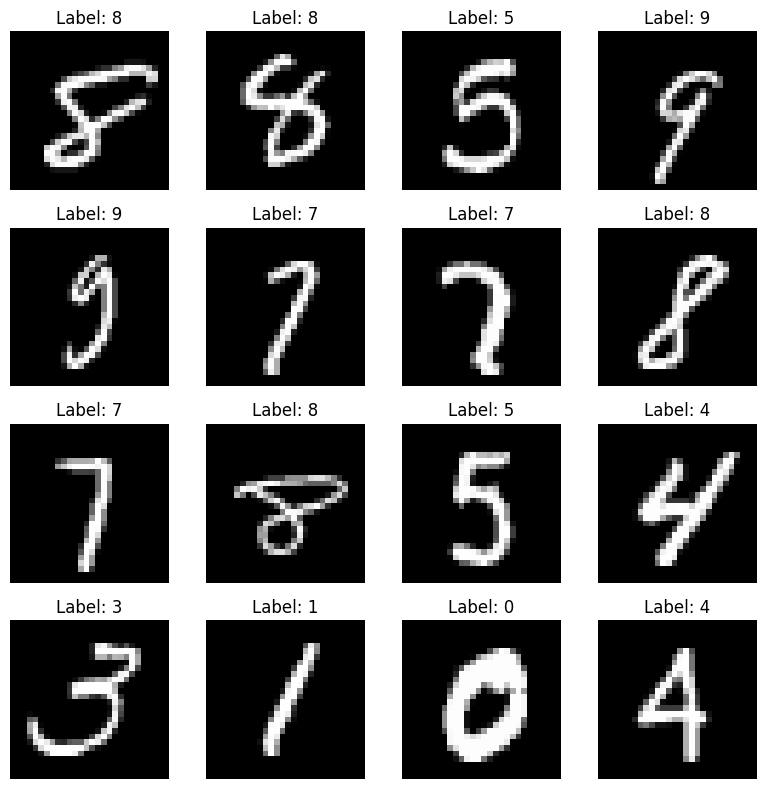

In [86]:
visualize_mnist(mnist_trainset)

## DDIM

## Forward Diffusion

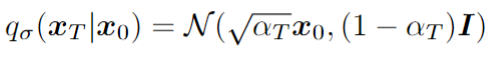
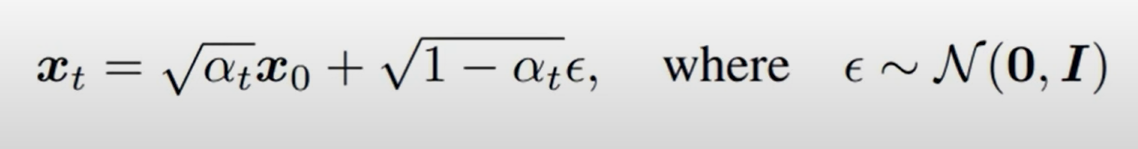

In [95]:

# param
T = 100
betas = torch.linspace(1e-2, 0.2, T)
alphas = 1 - betas
alphas = torch.cumprod(alphas, dim=0)               

# forward diffusion
def q_sample(x0, t, alphas):
    batch_size = x0.size(0)
    noise = torch.randn_like(x0)
    # Récupération des alphas correspondant aux indices temporels t
    sqrt_alpha_t = torch.sqrt(alphas.gather(0, t)).view(batch_size, 1, 1, 1)
    sqrt_one_minus_alpha_t = torch.sqrt((1 - alphas).gather(0, t)).view(batch_size, 1, 1, 1)
    return sqrt_alpha_t * x0 + sqrt_one_minus_alpha_t * noise

def q_sample_unique(x0, t, alphas):
    noise = torch.randn_like(x0)
    sqrt_alpha_t = torch.sqrt(alphas[t])
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alphas[t])

    return sqrt_alpha_t * x0 + sqrt_one_minus_alpha_t * noise


# visualisation
def visualize_diffusion_step(image, alphas, num_steps=10):
    fig, axes = plt.subplots(1, num_steps+1, figsize=(15, 15))
    axes[0].imshow(image.squeeze().cpu().numpy(), cmap="gray")
    axes[0].axis('off')
    for step in range(num_steps):
        t = int(len(alphas) * step / num_steps) 
        xt = q_sample_unique(image, t, alphas)
        axes[step+1].imshow(xt.squeeze().cpu().numpy(), cmap="gray")
        axes[step+1].axis('off')
    
    plt.show()

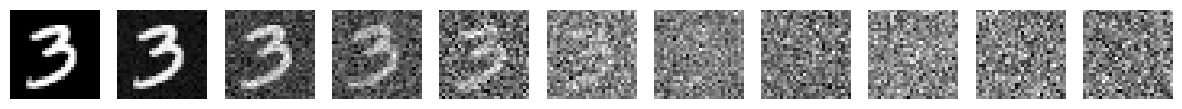

In [96]:
train_loader = DataLoader(mnist_trainset, batch_size=1, shuffle=True)
sample_image, _ = next(iter(train_loader)) 

visualize_diffusion_step(sample_image[0], alphas)

## Backward Diffusion

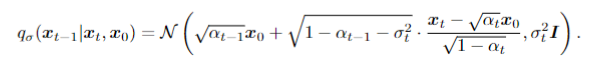

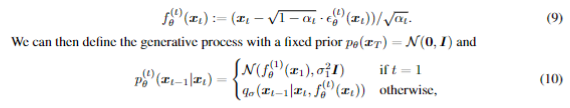

In [11]:
@torch.no_grad()
def f_teta(x_t, alpha_t, eps_theta) :
    return (x_t - torch.sqrt(1-alpha_t) * eps_theta) / torch.sqrt(alpha_t)

@torch.no_grad()
def p_sample(x_t, t, alphas, esp_theta, sigmas) :
    
    alpha_t = alphas[t]
    alpha_t_1 = alphas[t-1]
    sigma_t = sigmas[t]
    x0_pred = f_teta(x_t, alpha_t, esp_theta)
    
    if t > 1 :
        mean = ((torch.sqrt(alpha_t_1)) * x0_pred + 
            torch.sqrt(1 - alpha_t_1 - sigma_t**2 ) *
            (x_t - torch.sqrt(alpha_t) * x0_pred) / 
            torch.sqrt(alpha_t) 
            )
        
        noise = sigma_t * torch.randn_like(x_t)
        x_t_1 = mean + noise
    
    else :
        # si t == 1
        mean = x0_pred
        noise = sigma_t * torch.randn_like(x_t)
        x_t_1 = mean + noise
        
    return x_t_1


In [12]:
@torch.no_grad()
def ddim_sample(x_T, t, eps_theta, sigmas, num_step) :
    
    x_t= x_T
    for t in range(num_step) :
        x_t = p_sample(x_t, t, alphas, eps_theta, sigmas)
    return x_t

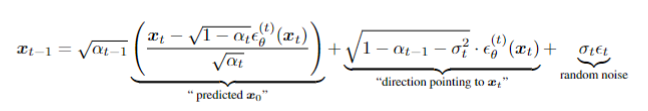

torch.Size([28, 28])


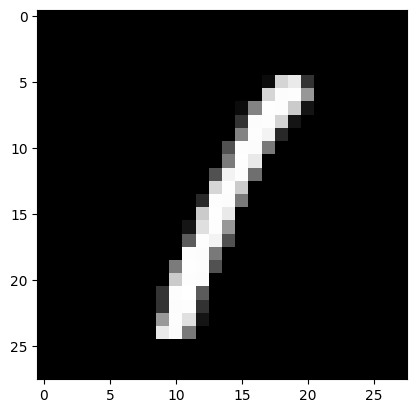

In [88]:
batch_size = 64
dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
for batch in dataloader :
    images, _ = batch
    image = images[0][0]
    print(image.shape)
    plt.imshow(image, cmap="gray")
    break

## Complexe Model

### Sinusoidale timestamp Embedding

This part is a classic temporal embedding block which is very widespread and which allows us to add temporal information to our model, which is very important in diffusion models. It is used, for example, by transformers to know the position of a word in a sentence.

In [51]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta=10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

### Backward diffusion process with U-Net

For backward diffusion, we'll use a U-Net architecture. The U-Net architecture is an iterative block that follows image downscaling and upscaling, training to learn noise from $x_{t}$ to $x_{t-1}$.

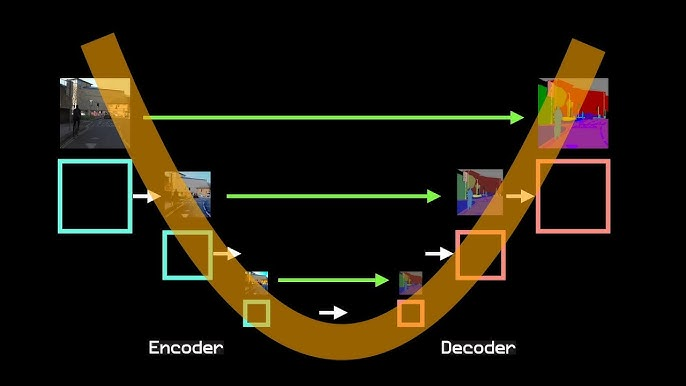

In [52]:
class Block(nn.Module):
    def __init__(self, input_channel, output_channel, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, output_channel)
        if up:
            self.conv1 = nn.Conv2d(2 * input_channel, output_channel, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(output_channel, output_channel, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(output_channel, output_channel, 4, 2, 1)

        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(output_channel)
        self.bnorm2 = nn.BatchNorm2d(output_channel)
        self.relu = nn.ReLU()

    def forward(self, image, time):
        h = self.bnorm1(self.relu(self.conv1(image)))
        time_emb = self.relu(self.time_mlp(time))
        time_emb = time_emb[(...,) + (None,) * 2]  # Extend dimensions for addition
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

In [53]:
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channel = 1  # Black-and-white images
        down_channel = (64, 128, 256, 512)
        up_channel = (512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channel, down_channel[0], kernel_size=3, padding=1)

        # Downsample
        self.down = nn.ModuleList([
            Block(down_channel[i], down_channel[i + 1], time_emb_dim)
            for i in range(len(down_channel) - 1)
        ])

        # Upsample
        self.up = nn.ModuleList([
            Block(up_channel[i], up_channel[i + 1], time_emb_dim, up=True)
            for i in range(len(up_channel) - 1)
        ])

        # Final output layer
        self.output = nn.Conv2d(up_channel[-1], out_dim, 1)

    def forward(self, images, timestep):
        # Time embedding
        t = self.time_mlp(timestep)

        # Initial convolution
        images = self.conv0(images)

        residual_inputs = []

        # Downsampling
        for down in self.down:
            images = down(images, t)
            residual_inputs.append(images)

        # Upsampling
        for up in self.up:
            residual_images = residual_inputs.pop()

            # Adjust dimensions to match
            diff_h = residual_images.size(2) - images.size(2)
            diff_w = residual_images.size(3) - images.size(3)

            if diff_h > 0 or diff_w > 0:
                images = F.pad(images, (0, diff_w, 0, diff_h))
            elif diff_h < 0 or diff_w < 0:
                residual_images = residual_images[:, :, :images.size(2), :images.size(3)]
            images = torch.cat((images, residual_images), dim=1)
            images = up(images, t)
        output = self.output(images)
        return output

In [54]:
model = UNet()
images = torch.randn(1, 1, 28, 28)  # Exemple d'image batch
timestep = torch.randint(0, 100, (1,))  # Timestep
output = model(images, timestep)

### Loss Function

In [55]:
def weighted_loss(predicted_noise, real_noise, t, alphas):
    alpha_t = alphas[t].view(-1, 1, 1, 1)
    weight = 1 / torch.sqrt(alpha_t)
    return torch.mean(weight * (predicted_noise - real_noise) ** 2)

### Training

In [57]:
epochs = 1
batch_size = 8
learning_rate = 1e-3
time_emb_dim = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Créer les DataLoaders
train_dataloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(mnist_valset, batch_size=batch_size, shuffle=False, drop_last=True)

# Modèle, critère et optimiseur
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    step = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Training"):
        images, _ = batch
        images = images.view(batch_size, 1, 28, 28)
        t = torch.randint(0, T, (batch_size,), device=device).long()
        
        noise = torch.randn_like(images)
        x_t = q_sample(images, t, alphas).view(batch_size, 1, 28, 28)
        
        noise_pred = model(x_t, t)
        loss = weighted_loss(noise_pred, noise, t, alphas)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    if epoch % 10 == 0 :
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")

Epoch 1 - Training:   0%|          | 11/6000 [00:02<25:28,  3.92it/s]


KeyboardInterrupt: 